# Actividad para resolver la tarea de identificación de Captchas

**Autores: Santiago Guerrero y Juan Esteban Arevalo**

Hemos estudiado y comprendido los conceptos de redes convolucionales, sus principales arquitecturas y su aplicación en tareas de clasificación de imágenes. Ahora, es momento de aplicar estos conocimientos en una tarea particular: la identificación de Captchas. Para este problema, usamos la base de datos disponible en [Captcha](https://www.researchgate.net/publication/248380891_CAPTCHA_dataset).

## Etapa 1: Carga de los datos

In [1]:
import numpy as np

%matplotlib inline
from keras.utils import plot_model
import matplotlib.pyplot as plt
import os
from keras import layers
from keras.models import Model
from keras.models import load_model
import cv2
import string
import tensorflow as tf
from tensorflow import keras

Se descarga la base de datos como un archivo `.zip`, el archivo quedará almacenado dentro de la sesión de Google Colab, no ocupa espacio en nuestro disco.

In [2]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1EcTWqMW8tLYQ32_MXg2m_xrWo1w0AqXf' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1EcTWqMW8tLYQ32_MXg2m_xrWo1w0AqXf" -O "Data.zip" && rm -rf /tmp/cookies.txt

--2024-05-25 13:51:16--  https://docs.google.com/uc?export=download&confirm=&id=1EcTWqMW8tLYQ32_MXg2m_xrWo1w0AqXf
Resolving docs.google.com (docs.google.com)... 142.250.141.113, 142.250.141.138, 142.250.141.139, ...
Connecting to docs.google.com (docs.google.com)|142.250.141.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1EcTWqMW8tLYQ32_MXg2m_xrWo1w0AqXf&export=download [following]
--2024-05-25 13:51:17--  https://drive.usercontent.google.com/download?id=1EcTWqMW8tLYQ32_MXg2m_xrWo1w0AqXf&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.2.132, 2607:f8b0:4023:c0d::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10036086 (9.6M) [application/octet-stream]
Saving to: ‘Data.zip’

Data.zip            100%[===================>]   9.57M  53.1MB/

In [3]:
# Se descomprime el archivo zip para acceder a las imágenes.
!unzip Data.zip -d Data

Archive:  Data.zip
   creating: Data/captcha_dataset/
  inflating: Data/__MACOSX/._captcha_dataset  
  inflating: Data/captcha_dataset/.DS_Store  
  inflating: Data/__MACOSX/captcha_dataset/._.DS_Store  
  inflating: Data/captcha_dataset/ml_data_3188.csv  
  inflating: Data/__MACOSX/captcha_dataset/._ml_data_3188.csv  
   creating: Data/captcha_dataset/samples/
  inflating: Data/__MACOSX/captcha_dataset/._samples  
  inflating: Data/captcha_dataset/ml_test_3188.csv  
  inflating: Data/__MACOSX/captcha_dataset/._ml_test_3188.csv  
  inflating: Data/captcha_dataset/samples/p5g5m.png  
  inflating: Data/__MACOSX/captcha_dataset/samples/._p5g5m.png  
  inflating: Data/captcha_dataset/samples/e72cd.png  
  inflating: Data/__MACOSX/captcha_dataset/samples/._e72cd.png  
  inflating: Data/captcha_dataset/samples/pgmn2.png  
  inflating: Data/__MACOSX/captcha_dataset/samples/._pgmn2.png  
  inflating: Data/captcha_dataset/samples/6cm6m.png  
  inflating: Data/__MACOSX/captcha_dataset/samples/._

In [4]:
# Se calcula la cantidad de imágenes en la base de datos
N = len(os.listdir("Data/captcha_dataset/samples"))
print(N)

1070


In [5]:
# Se define el tamaño de las imágenes requerido.
Ishape=(50,200,1) # Un canal debido a que son imágenes en escala de grises

In [6]:
# Número de posibles caracteres en las imágenes
character= string.ascii_lowercase + "0123456789" # todos los símbolos que puede
                                                 # contener un captcha, las letras
                                                 # del abecedario y los números
                                                 # [0,9]
# número de posibles caracteres
N_char = len(character)
N_char

36

Se definen algunas funciones importantes para la carga y procesamiento de las imágenes.

In [7]:
# Función para la carga y proceso de las imágenes.
def load_process():
  X = np.zeros((N,)+Ishape) # Arreglo que contiene las imágenes.
  y = np.zeros((N, 5)) # Arreglo que contiene las etiquetas.
  lab = [] # se almacenan las etiquetas en formato de texto.

  # Se cargan las imágenes de la base de datos
  file_dir = 'Data/captcha_dataset/samples'
  for i, ima in enumerate(os.listdir(file_dir)):

    # Se leen las imágenes en escala de grises.
    img = cv2.imread(os.path.join(file_dir, ima), cv2.IMREAD_GRAYSCALE)
    label = ima[:-4] # el nombre del archivo que corresponde con su etiqueta
    if len(label) < 6:
      lab.append(label)
      img = img / 255.0 # se reescala la imagen
      img = np.reshape(img, Ishape) # se cambia el tamaño de las imágenes

      # Convierte cada caracter de la etiqueta en un número. Por ejemplo, el
      # caracter 'a' se codifica como 0.
      for j, car in enumerate(label):
         index = character.find(car)
         y[i,j] = index

      X[i,:] = img


  return X, y, lab


<ipython-input-9-121f3f6a6eab>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,2,i+1)


(1070, 5)


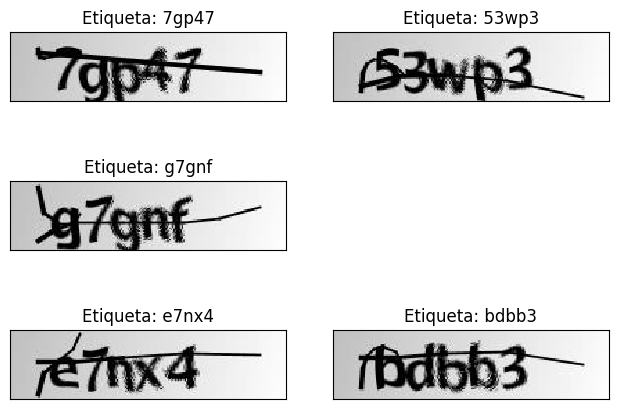

In [9]:
# Se cargan los datos y se muestran algunas imágenes
X, y, label = load_process()
fig = plt.figure()
for i in range(6):
  plt.subplot(3,2,i+1)
  plt.tight_layout()
  plt.imshow(X[i,:,:,0], cmap='gray', interpolation='none')
  plt.title("Etiqueta: {}".format(label[i]))
  plt.xticks([])
  plt.yticks([])
fig



In [ ]:
print(X.shape, y.shape)

(1070, 50, 200, 1) (1070, 5)


Se definen los datos de entrenamiento y prueba.

In [11]:
# De las 1070 muestras, se usan 970 para el entrenamiento y 100 para la prueba.
x_train, y_train = X[:970,:,:,:], y[:970,:]
x_test, y_test = X[970:,:,:,:], y[970:,:]

print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(100, 50, 200, 1)
(970, 5)
(100, 5)


# Enfoque secuencial con matriz softmax

In [ ]:
# Define the model
model = keras.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=(8, 8), padding="valid",
                        strides=(1, 1), activation='relu', input_shape=(50, 200, 1)),
    keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    keras.layers.Conv2D(filters=16, kernel_size=(8, 8), padding="valid",
                        strides=(1, 1), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(5 * 36, activation='softmax', name='output_layer')
])

# Se reajusta la capa de salida para que quede como un array 5x36, donde las filas son
#las posiciones del captcha y las columnas las probabilidades de que sea un determinado
#caracter
model.add(keras.layers.Reshape((5, 36)))


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 43, 193, 32)       2080      
                                                                 
 max_pooling2d_30 (MaxPooli  (None, 21, 96, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_31 (Conv2D)          (None, 14, 89, 16)        32784     
                                                                 
 max_pooling2d_31 (MaxPooli  (None, 7, 44, 16)         0         
 ng2D)                                                           
                                                                 
 flatten_15 (Flatten)        (None, 4928)              0         
                                                                 
 dropout_15 (Dropout)        (None, 4928)            

In [ ]:

model.fit(x_train, y_train, epochs=100, batch_size=64, validation_data=(x_test, y_test))


test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print('Test accuracy:', test_acc)

Epoch 1/100
16/16 [==============================] - 3s 59ms/step - loss: 3.1319 - accuracy: 0.0668 - val_loss: 2.9476 - val_accuracy: 0.1140
Epoch 2/100
16/16 [==============================] - 0s 15ms/step - loss: 2.9015 - accuracy: 0.1070 - val_loss: 2.7839 - val_accuracy: 0.1480
Epoch 3/100
16/16 [==============================] - 0s 14ms/step - loss: 2.6186 - accuracy: 0.1988 - val_loss: 2.3219 - val_accuracy: 0.3400
Epoch 4/100
16/16 [==============================] - 0s 15ms/step - loss: 1.9122 - accuracy: 0.4260 - val_loss: 1.6930 - val_accuracy: 0.5120
Epoch 5/100
16/16 [==============================] - 0s 14ms/step - loss: 1.2713 - accuracy: 0.6256 - val_loss: 1.3141 - val_accuracy: 0.6120
Epoch 6/100
16/16 [==============================] - 0s 14ms/step - loss: 0.8635 - accuracy: 0.7353 - val_loss: 1.0829 - val_accuracy: 0.6660
Epoch 7/100
16/16 [==============================] - 0s 14ms/step - loss: 0.6039 - accuracy: 0.8099 - val_loss: 0.9462 - val_accuracy: 0.7340
Epoch 

4/4 [==============================] - 0s 4ms/step


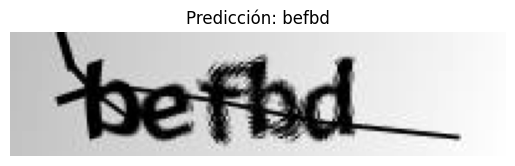

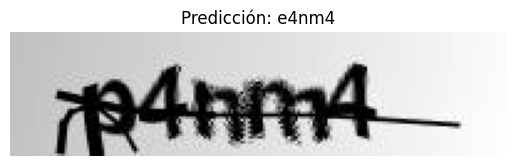

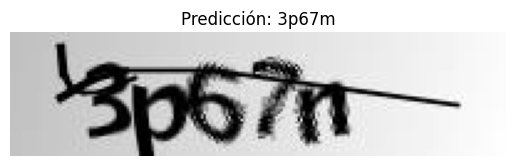

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#Esta sección de código ayuda a imprimir las imágenes y les pone como título la predicción
#mapeada

predictions = model.predict(x_test)

predicted_characters = []
for pred in predictions:
    characters = []
    for char_pred in pred:
        characters.append(np.argmax(char_pred))
    predicted_characters.append(characters)


mapping = {i: chr(i + 97) if i < 26 else str(i - 26) for i in range(36)}


predicted_strings = []
for pred in predicted_characters:
    chars = [mapping[char] for char in pred]
    predicted_strings.append(''.join(chars))

num_images_to_show = 3
for i in range(num_images_to_show):
    plt.imshow(x_test[i].reshape(50, 200), cmap='gray')
    plt.title('Predicción: ' + predicted_strings[i])
    plt.axis('off')
    plt.show()

# Enfoque de múltiples salidas

In [113]:
def createmodel():
    # se define una serie de capas convolucionales.
    img = layers.Input(shape=(Ishape))
    conv1 = layers.Conv2D(16, (3, 3), padding='same', activation='relu')(img)
    mp1 = layers.MaxPooling2D(padding='same')(conv1)
    conv2 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp1)
    mp2 = layers.MaxPooling2D(padding='same')(conv2)
    conv3 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp2)
    bn = layers.BatchNormalization()(conv3)
    mp3 = layers.MaxPooling2D(padding='same')(bn)

    flat = layers.Flatten()(mp3)


    outs = [] # En esta lista se guardan las salidas


    # Salida 1: Clasificación con 36 clases. (caractéres)
    den_1 = layers.Dense(60, activation='selu')(flat)
    drop_1 = layers.Dropout(0.5)(den_1)
    sal_1 = layers.Dense(36, activation='Softmax')(drop_1)
    outs.append(sal_1) #se añade el resultado a la lista

        # Salida 2: Clasificación con 36 clases. (caractéres)
    den_2 = layers.Dense(60, activation='selu')(flat)
    drop_2 = layers.Dropout(0.5)(den_2)
    sal_2 = layers.Dense(36, activation='Softmax')(drop_2)
    outs.append(sal_2) #se añade el resultado a la lista

        # Salida 3: Clasificación con 36 clases. (caractéres)
    den_3 = layers.Dense(60, activation='selu')(flat)
    drop_3 = layers.Dropout(0.5)(den_3)
    sal_3 = layers.Dense(36, activation='Softmax')(drop_3)
    outs.append(sal_3) #se añade el resultado a la lista

        # Salida 4: Clasificación con 36 clases. (caractéres)
    den_4 = layers.Dense(60, activation='selu')(flat)
    drop_4 = layers.Dropout(0.5)(den_4)
    sal_4 = layers.Dense(36, activation='Softmax')(drop_4)
    outs.append(sal_4) #se añade el resultado a la lista

        # Salida 5: Clasificación con 36 clases. (caractéres)
    den_5 = layers.Dense(60, activation='selu')(flat)
    drop_5 = layers.Dropout(0.5)(den_5)
    sal_5 = layers.Dense(36, activation='Softmax')(drop_5)
    outs.append(sal_5) #se añade el resultado a la lista



    # Compile model and return it
    model = Model(img, outs) #create model
    # Se crea una lista de funciones Loss, una por cada salida. Todas son salidas sparse_categorical_crossentropy
    Loss = ['sparse_categorical_crossentropy','sparse_categorical_crossentropy','sparse_categorical_crossentropy','sparse_categorical_crossentropy','sparse_categorical_crossentropy']
    model.compile(loss=Loss, optimizer='adam',metrics=["accuracy"])
    return model

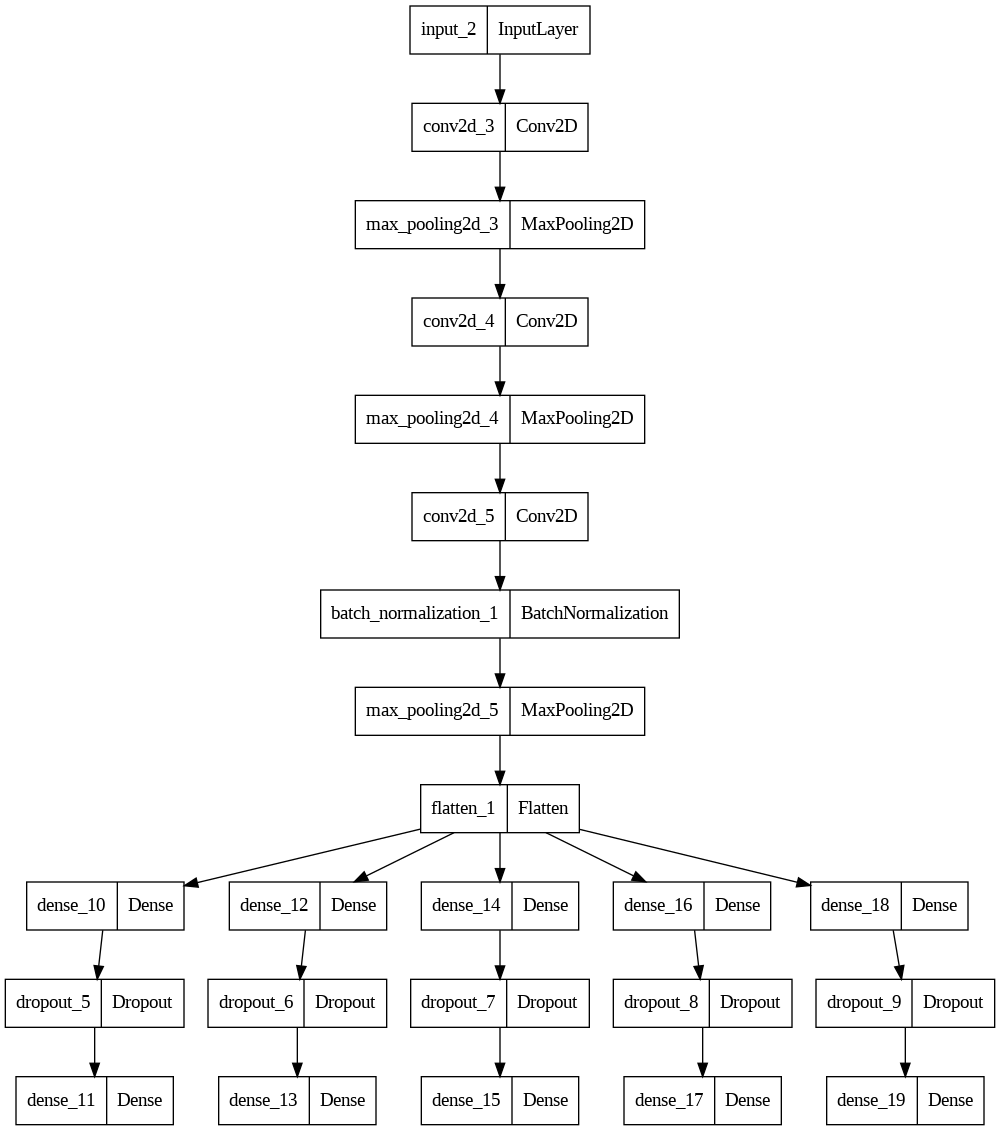

In [114]:
model_2 = createmodel()
tf.keras.utils.plot_model(model_2)

In [117]:
hist = model_2.fit(x_train, [ y_train[:,0],
                           y_train[:,1],
                           y_train[:,2],
                            y_train[:,3],
                            y_train[:,4]]
                           , batch_size=32, epochs=60,
                           validation_data=(x_test, [y_test[:,0],
                                                     y_test[:,1],
                                                     y_test[:,2],
                                                     y_test[:,3],
                                                     y_test[:,4]])) #el ejemplo que está ejecutado se entreno con 50 épocas y después con 60, es decir se reentrenó

Epoch 1/60
31/31 [==============================] - 1s 25ms/step - loss: 0.0951 - dense_11_loss: 0.0037 - dense_13_loss: 0.0148 - dense_15_loss: 0.0274 - dense_17_loss: 0.0156 - dense_19_loss: 0.0335 - dense_11_accuracy: 0.9990 - dense_13_accuracy: 0.9948 - dense_15_accuracy: 0.9928 - dense_17_accuracy: 0.9979 - dense_19_accuracy: 0.9907 - val_loss: 2.2771 - val_dense_11_loss: 0.0341 - val_dense_13_loss: 0.4142 - val_dense_15_loss: 0.5244 - val_dense_17_loss: 0.7779 - val_dense_19_loss: 0.5265 - val_dense_11_accuracy: 0.9900 - val_dense_13_accuracy: 0.9400 - val_dense_15_accuracy: 0.9100 - val_dense_17_accuracy: 0.8400 - val_dense_19_accuracy: 0.8900
Epoch 2/60
31/31 [==============================] - 0s 14ms/step - loss: 0.0732 - dense_11_loss: 0.0013 - dense_13_loss: 0.0216 - dense_15_loss: 0.0152 - dense_17_loss: 0.0130 - dense_19_loss: 0.0220 - dense_11_accuracy: 1.0000 - dense_13_accuracy: 0.9948 - dense_15_accuracy: 0.9959 - dense_17_accuracy: 0.9969 - dense_19_accuracy: 0.9907 -

4/4 [==============================] - 0s 4ms/step


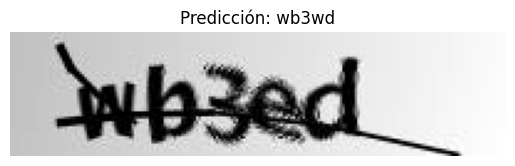

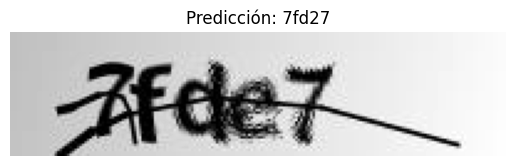

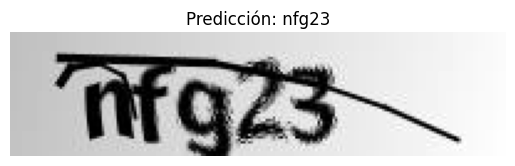

In [119]:
import numpy as np
import matplotlib.pyplot as plt




predictions = model_2.predict(x_test)

#la predicción es una lista que contiene 5 arrays de 100x36
#la idea es que predicted_characters_0 al 4 queden como listas de longitud 100
#donde cada una de las posiciones contenga el indice de la predicción mas probable
predictions_0=predictions[0]

predicted_characters_0= []
for i in range(100):

    characters_0=np.argmax(predictions_0[i,:])
    predicted_characters_0.append(characters_0)


#-------------------------------------------------------------------
predictions_1=predictions[1]

predicted_characters_1= []
for i in range(100):

    characters_1=np.argmax(predictions_1[i,:])
    predicted_characters_1.append(characters_1)


#-------------------------------------------------------------------
predictions_2=predictions[2]

predicted_characters_2= []
for i in range(100):

    characters_2=np.argmax(predictions_2[i,:])
    predicted_characters_2.append(characters_2)


#-------------------------------------------------------------------
predictions_3=predictions[3]

predicted_characters_3= []
for i in range(100):

    characters_3=np.argmax(predictions_3[i,:])
    predicted_characters_3.append(characters_3)


#-------------------------------------------------------------------
predictions_4=predictions[4]

predicted_characters_4= []
for i in range(100):

    characters_4=np.argmax(predictions_4[i,:])
    predicted_characters_4.append(characters_4)


mapping = {i: chr(i + 97) if i < 26 else str(i - 26) for i in range(36)} #diccionario que ayuda a pasar de numeros a caracteres

predicted_characters=array = np.column_stack((predicted_characters_0, predicted_characters_1, predicted_characters_2,predicted_characters_3,predicted_characters_4))
#predicted_characters tiene tamaño 100x5
predicted_strings = []
#llena una lista llamada predicted strings con los mapeos de cada una de las filas
#de predicted_characters
for k in range(100):
  pred=predicted_characters[k,:]
  chars = [mapping[char] for char in pred]
  predicted_strings.append(''.join(chars)) #join hace que los 5 caracteres queden juntos


#imprime las imagenes y les asigna como titulo la predicción
num_images_to_show = 3
for i in range(num_images_to_show):
    plt.imshow(x_test[i].reshape(50, 200), cmap='gray')
    plt.title('Predicción: ' + predicted_strings[i])
    plt.axis('off')
    plt.show()


# Conclusiones

El primer enfoque nos dá un accuracy de 88% sin utilizar multiples salidas, sin embargo, los resultados obtenidos no son favorables puesto que comparando las imagenes con las predicciones, notamos que el modelo ha cometido varios errores y no ha entregado un captcha completamente correcto. Por otra parte, el enfoque de multiples salidas ha obtenido un accuracy máximo del 99% (solo para la primera salida) y se logró obtener un captcha completamente correcto. Las virutdes que se pudieron observar del enfoque de multiples salidas ha sido, mayor velocidad de entrenamiento, menor sobreajuste, mayor precisión, menor loss y que las ramificaciones pueden contener diferente cantidad de neuronas y capas, por lo cual en aplicaciones más complejas se puede ajustar de forma heterogénea para obtener mejores resultados.